<a href="https://colab.research.google.com/github/julian-west/kaggle/blob/master/nlp-getting-started/BERT-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT Classification Model

Simple BERT model for the [Kaggle Real or Not? NLP with Disaster Tweets](https://www.kaggle.com/c/nlp-getting-started/overview) competition.

This notebook achieves a score of about 0.81.

# Standard Imports

In [0]:
import re
import time
import datetime

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# Load Datafiles

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
DATA_LOCATION = "/content/drive/My Drive/kaggle/nlp-getting-started/"

train_df = pd.read_csv(DATA_LOCATION + "train.csv")
test_df = pd.read_csv(DATA_LOCATION + "test.csv")

In [4]:
display(train_df.head())
display(test_df.head())

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


# Modelling

## PyTorch Imports

In [5]:
!pip install transformers

In [6]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, RandomSampler, TensorDataset

from transformers import BertModel, BertTokenizer, BertForSequenceClassification 
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup

from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


## LoadDataset Class

Class to load and preprocess the training data.

In [0]:
class TweetProcessor:

  def __init__(self, tweets, labels=[], maxlen=64):
    self.tweets = tweets
    self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    self.maxlen = maxlen
    self.labels = labels


  def process_text(self):
    """processes tweets and convert to tensors for BERT model"""
  
    #remove html
    self.tweets = self.tweets.apply(
        lambda x: re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+","",x))
    
    #convert to BERT encoded IDs
    input_ids = [self.tokenizer.encode(
        t, add_special_tokens = True) for t in self.tweets]

    #padd sequences
    input_ids = pad_sequences(input_ids, maxlen=self.maxlen,
                              dtype='long', value=0, 
                              truncating='post', padding='post'
                              )

    #create masks for each tweet (1 if token >0 else 0)
    att_masks = [[int(token_id > 0) for token_id in input_id
                       ] for input_id in input_ids]

    input_ids_tensors = torch.tensor(input_ids)
    att_masks_tensors = torch.tensor(att_masks)


    if len(self.labels) == len(self.tweets):
      labels_tensors = torch.tensor(self.labels.ravel())
      return input_ids_tensors, att_masks_tensors, labels_tensors
    else:
      return input_ids_tensors, att_masks_tensors





## Training validation split

Split training data into train and validation sets.

In [0]:
SEED = 42
TEST_SIZE = 0.1
BATCH_SIZE = 32

train_data, val_data = train_test_split(
    train_df,
    random_state = SEED,
    test_size = 0.1,
    shuffle=True
)

train_inputs, train_masks, train_labels = TweetProcessor(
    train_data['text'], 
    labels=train_data['target']).process_text()

val_inputs, val_masks, val_labels = TweetProcessor(
    val_data['text'], 
    labels=val_data['target']).process_text()

In [0]:
train_data = TensorDataset(train_inputs, train_masks, train_labels)
val_data = TensorDataset(val_inputs, val_masks, val_labels)

train_sampler = RandomSampler(train_data)
val_sampler = RandomSampler(val_data)

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, 
                              sampler = train_sampler)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE,
                            sampler=val_sampler)

## Building the model

In [0]:
#number of traning epochs
EPOCHS = 7

In [0]:
#BERT model
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 2,
    output_attentions = False,
    output_hidden_states = False,
    )


#Optimizer
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8
                  )

#create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = len(train_dataloader) * EPOCHS
    )


## Model Training

### Utility Functions

In [0]:
def flat_accuracy(preds, labels):
  pred_flat = np.argmax(preds,axis=1).flatten()
  labels_flat = labels.flatten()
  return np.sum(pred_flat == labels_flat)/len(labels_flat)


#format the time 
def format_time(elapsed):
  elapsed_rounded = int(round((elapsed)))
  return str(datetime.timedelta(seconds = elapsed_rounded))

### Training loop

In [14]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

print(f"Using {device}")

Using cuda


In [0]:
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [0]:
def validate_model(nnet, val_dataloader, device):
  """Evaluate current model on validation set"""

  t0 = time.time()

  nnet.eval()

  loss, accuracy = 0, 0
  
  eval_steps = 0
  for batch in val_dataloader:
    b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)
  
    with torch.no_grad():
      #get predictions 
      outputs = nnet(b_input_ids, 
                     token_type_ids = None,
                     attention_mask = b_input_mask)

    #calc loss
    logits = outputs[0].detach().cpu().numpy()
    labels = b_labels.to('cpu').numpy()

    tmp_accuracy = flat_accuracy(logits, labels)
    
    accuracy += tmp_accuracy

    eval_steps += 1

  print(f"----Accuracy: {accuracy/eval_steps}")
  print(f"----Validation took {format_time(time.time() - t0)}")

  return accuracy/eval_steps

In [0]:
def train(nnet, optimizer, train_dataloader, val_dataloader, device, epochs=EPOCHS):

  nnet.to(device)
  nnet.train()

  #store loss values to plot after training
  loss_values = []
  val_loss = []
  val_accuracy = []

  print("=============== STARTING TRAINING ===============")
  t0 = time.time()

  for epoch in range(epochs):

    print(f"\n\n======= EPOCH {epoch+1} =======")
    t1 = time.time()
    total_loss = 0

    for step, batch in enumerate(train_dataloader):

      if step % 40 == 0 and not step == 0:
        elapsed = format_time(time.time() - t1)
        print(f"    Batch {step} of {len(train_dataloader)}. Elapsed time {elapsed}")


      #move inputs to device
      b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)

      #zero gradients
      nnet.zero_grad()

      #perform forward pass
      outputs = nnet(
          b_input_ids,
          token_type_ids = None,
          attention_mask = b_input_mask,
          labels = b_labels
          )
      
      loss = outputs[0]
      total_loss += loss.item()

      #back propagate the gradients
      loss.backward()

      #clip gradients to tackle exploding gradients problem
      torch.nn.utils.clip_grad_norm_(model.parameters(),1.0)

      #update parameters and take a step using the computed gradient
      optimizer.step()

      #update learning rate
      scheduler.step()

    avg_train_loss = total_loss/len(train_dataloader)

    loss_values.append(avg_train_loss)

    print("")
    print(f"   Average training loss: {avg_train_loss:.2f}")
    print(f"   Training epoch took: {format_time(time.time() - t1)}")

    print(f"\n\n======= Running Validation =======")
    val_accuracy = validate_model(nnet,val_dataloader,device)


  print("\n\n\n TRAINING COMPLETED!")
  total_time = format_time(time.time() - t0)
  print(f"------ Training took {total_time}")

  return loss_values, val_accuracy

    



In [18]:
loss_values, val_accuracy = train(model, optimizer, train_dataloader, val_dataloader, device)

=============== STARTING TRAINING ===============


======= EPOCH 1 =======
    Batch 40 of 215. Elapsed time 0:00:19
    Batch 80 of 215. Elapsed time 0:00:38
    Batch 120 of 215. Elapsed time 0:00:58
    Batch 160 of 215. Elapsed time 0:01:17
    Batch 200 of 215. Elapsed time 0:01:36

   Average training loss: 0.46
   Training epoch took: 0:01:43


======= Running Validation =======
----Accuracy: 0.8389423076923076
----Validation took 0:00:03


======= EPOCH 2 =======
    Batch 40 of 215. Elapsed time 0:02:06
    Batch 80 of 215. Elapsed time 0:02:25
    Batch 120 of 215. Elapsed time 0:02:44
    Batch 160 of 215. Elapsed time 0:03:03
    Batch 200 of 215. Elapsed time 0:03:23

   Average training loss: 0.32
   Training epoch took: 0:01:43


======= Running Validation =======
----Accuracy: 0.827323717948718
----Validation took 0:00:03


======= EPOCH 3 =======
    Batch 40 of 215. Elapsed time 0:03:52
    Batch 80 of 215. Elapsed time 0:04:11
    Batch 120 of 215. Elapsed time 0:04

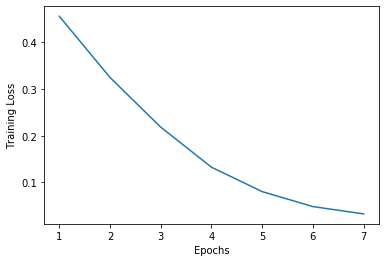

In [19]:
#plot loss values
plt.plot(range(1,EPOCHS+1),loss_values)
plt.ylabel("Training Loss")
plt.xlabel("Epochs")
plt.xticks([i for i in range(1,EPOCHS+1)])
plt.show()

# Make final predictions

In [0]:
test_inputs, test_masks = TweetProcessor(
    test_df['text'], 
    labels=[]).process_text()


test_data = TensorDataset(test_inputs, test_masks)

test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE)

In [25]:
predictions = []

model.eval()

for i, batch in enumerate(test_dataloader):
  if i % 40 == 0:
    print(f"\n Making predictions for batch {i} of {len(test_dataloader)}")

  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask = batch

  with torch.no_grad():
    outputs = model(b_input_ids, 
                    token_type_ids = None,
                    attention_mask = b_input_mask)
    
  logits = outputs[0]
  logits = logits.detach().cpu().numpy()

  predictions.append(logits)

print("\n   DONE   ")


 Making predictions for batch 0 of 102

 Making predictions for batch 40 of 102

 Making predictions for batch 80 of 102

   DONE   


In [0]:
#find argmax and flatten batches list
final_predictions = [i for j in range(len(predictions)) for i in np.argmax(predictions[j],axis=1)]

test_predictions = pd.DataFrame({'id':test_df['id'],'target':final_predictions})
test_predictions.to_csv("submission2.csv",index=False)